### Make the necessary imports (libraries)

In [4]:
# Import necessary libraries
import cnn_utils
from keras import layers, models
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


### Load the data

In [5]:
data_dict = cnn_utils.load_cifar10_from_tar()

CIFAR-10 tar file not found at cifar-10-python.tar
Download completed!
Loading CIFAR-10 data...
Loading training batch 1...
Loading training batch 2...
Loading training batch 3...
Loading training batch 4...
Loading training batch 5...
Loading test data...
Raw data loaded successfully!
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Preprocess the data

In [6]:
data = cnn_utils.preprocess_data(data_dict)

Preprocessing data...
Preprocessing completed!
Training: (45000, 32, 32, 3), Validation: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


### Let's do a quick visualization of sample images (to also ensure we still have the correct shape)

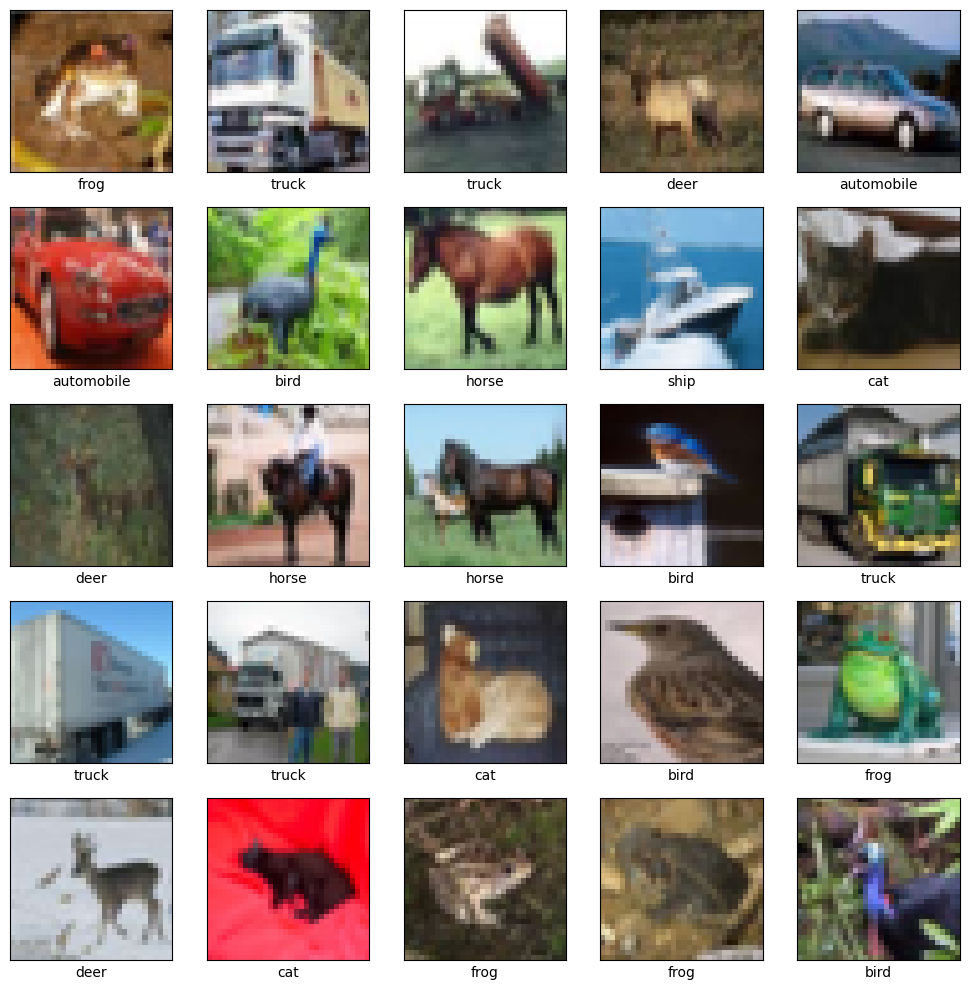

In [ ]:
cnn_utils.visualize_data_samples(data)

### Augmentation of the data
Mminimal/conservative augmentation designed to be very safe:
- Tiny transformations: Only 5% shifts and 5° rotation (vs typical 10-15%)
- Basic flip: Horizontal flip only (doubles dataset safely)

In [7]:
def apply_mild_data_augmentation():
    """Apply very conservative data augmentation"""
    return ImageDataGenerator(
        horizontal_flip=True,          # Only horizontal flip
        width_shift_range=0.05,        # Very small shifts (5%)
        height_shift_range=0.05,       # Very small shifts (5%)
        rotation_range=5               # Very small rotation (5 degrees)
    )

augmentation = apply_mild_data_augmentation()
augmentation.fit(data['X_train'])

### Let's define our CNN model (architect)
This is a ResNet-inspired CNN with lightweight residual blocks:

- Residual blocks: Each block has two 3x3 convolutions with skip connections (shortcut + projection layers)
- Progressive scaling: 32→64→128 filters with MaxPooling between blocks
- Modern features: BatchNormalization, GlobalAveragePooling (no Flatten)
- Compact design: Only 64 neurons in final dense layer


In [8]:
def residual_block(x, filters, use_projection=False):
    """Create a residual block with skip connection"""
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution (no activation yet)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut dimensions if needed
    if use_projection or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection and apply final activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [9]:
# Modified create_cnn_model function with residual blocks
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    # Use Functional API instead of Sequential for residual connections
    inputs = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # First residual block (32 filters)
    x = residual_block(x, filters=32, use_projection=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second residual block (64 filters)
    x = residual_block(x, filters=64, use_projection=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Third residual block (128 filters)
    x = residual_block(x, filters=128, use_projection=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Classifier (same as your simplified version)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [10]:
model = create_cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_utils.print_model_summary(model)


MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 319,466 (1.22 MB)

 Trainable params: 318,058 (1.21 MB)

 Non-trainable params: 1,408 (5.50 KB)


📊 Total Parameters: 319,466


In [11]:
from keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #,
]

history = cnn_utils.train_model(model, data, augmentation=augmentation, callbacks=callbacks)


Starting model training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.2551 - loss: 2.0323 - val_accuracy: 0.3506 - val_loss: 1.8461
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.4359 - loss: 1.5431 - val_accuracy: 0.4006 - val_loss: 1.9116
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.5108 - loss: 1.3495 - val_accuracy: 0.4916 - val_loss: 1.3919
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.5638 - loss: 1.2340 - val_accuracy: 0.5458 - val_loss: 1.2333
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.5861 - loss: 1.1629 - val_accuracy: 0.6082 - val_loss: 1.1117
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6070 - loss: 1.1087 - val_accuracy: 0.5682 - val_loss: 1.2622
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6307 - loss: 1.0502 - val_accuracy: 0.6500 - val_loss: 0.9788
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6505 - loss: 0.9954 - val_accurac

### Let's show the evaluation result

MODEL EVALUATION


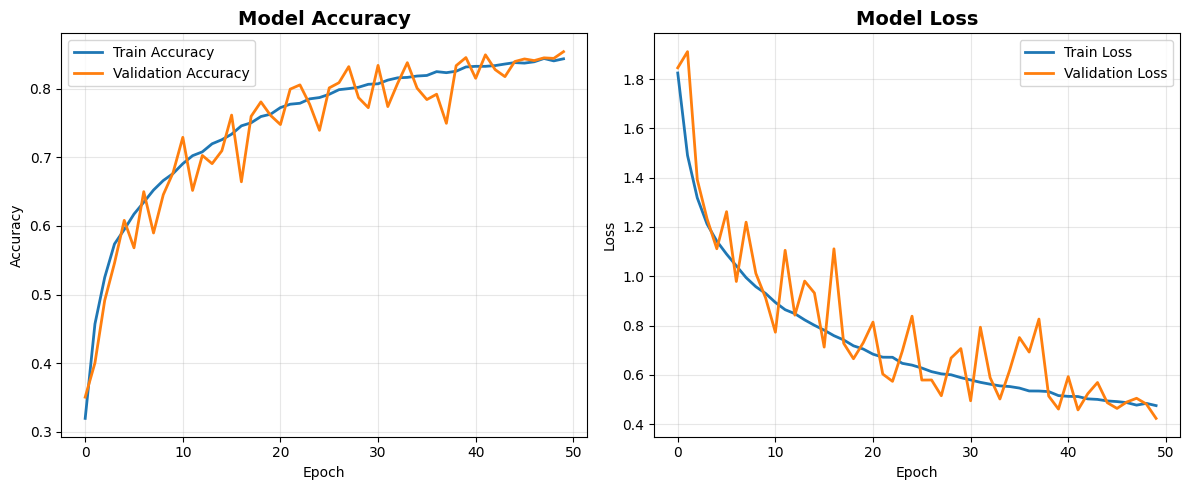


🎯 Final Test Results:
   Test Accuracy: 0.8446
   Test Loss: 0.4605

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.81      0.85      1000
  automobile       0.89      0.96      0.93      1000
        bird       0.68      0.88      0.77      1000
         cat       0.79      0.63      0.70      1000
        deer       0.90      0.74      0.81      1000
         dog       0.79      0.78      0.79      1000
        frog       0.82      0.92      0.87      1000
       horse       0.93      0.85      0.89      1000
        ship       0.92      0.93      0.92      1000
       truck       0.89      0.95      0.92      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



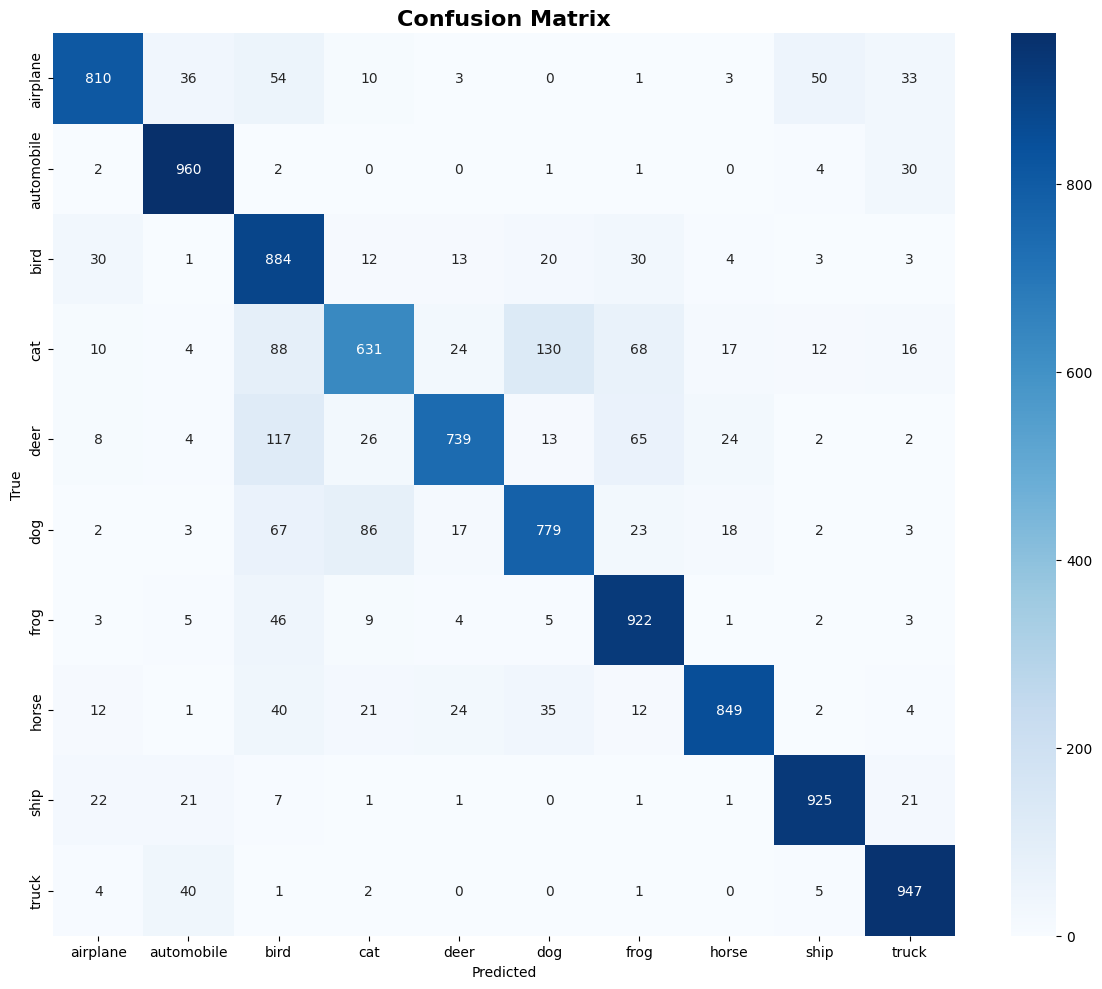

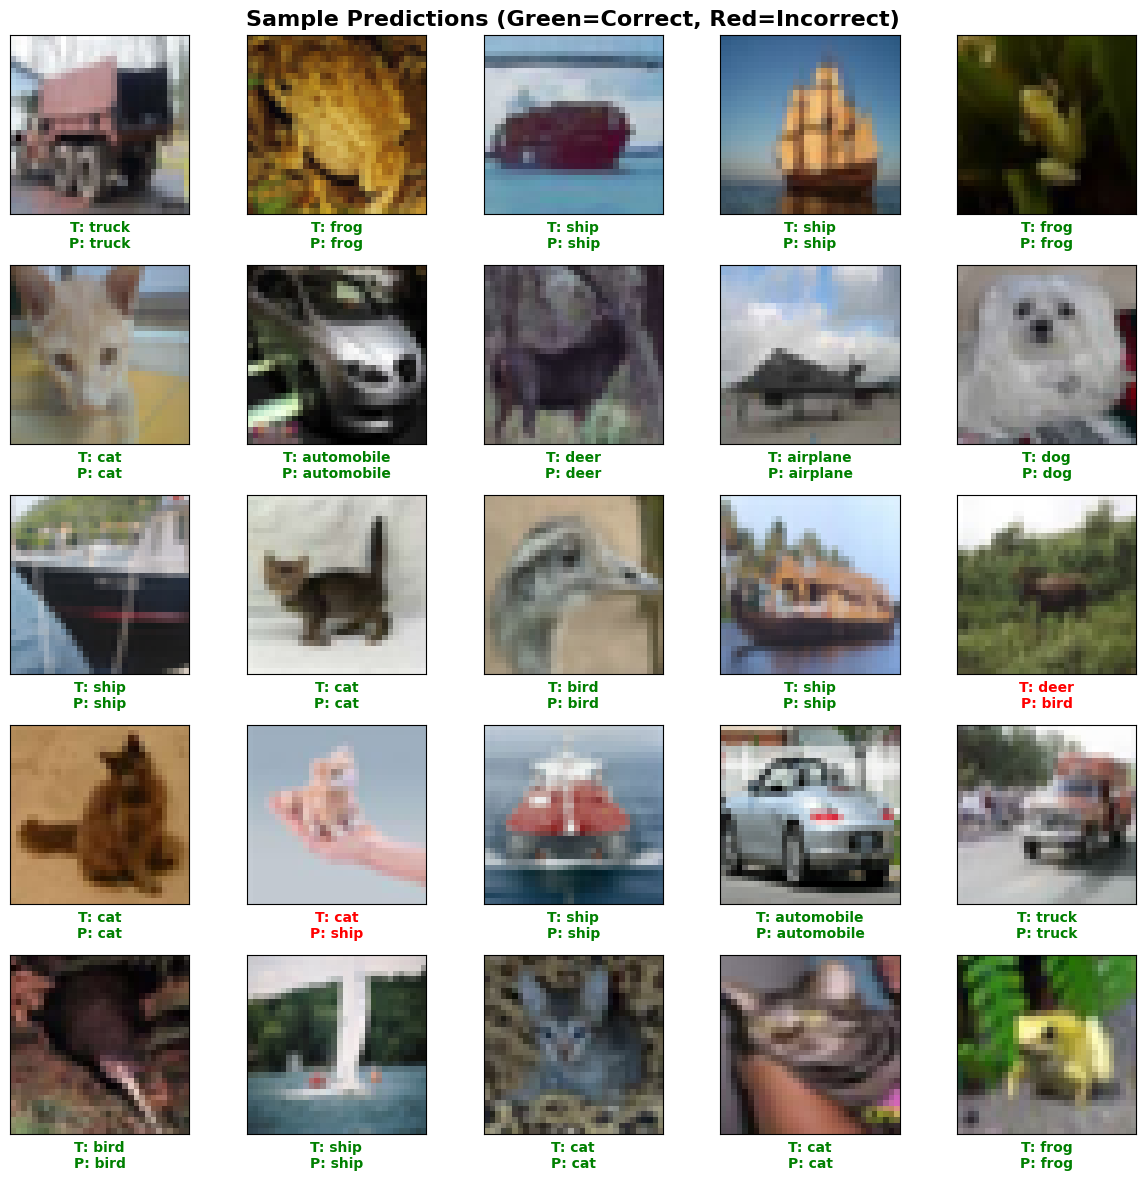

In [12]:
cnn_utils.evaluate_model(model, data, history)